In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
# import lime.lime_tabular as lime_tab
import lime.lime_tabular_mod as lime_tab
import matplotlib.pyplot as plt
import random

import importlib
importlib.reload(lime_tab)

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load iris dataset

In [2]:
iris_dataset = pd.read_csv(
    "../data/iris-classification/iris.data",
    names=[
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
        "label"
    ]).sample(frac=1)
iris_dataset

,sepal_length,sepal_width,petal_length,petal_width,label
147,6.5,3.0,5.2,2.0,Iris-virginica
69,5.6,2.5,3.9,1.1,Iris-versicolor
76,6.8,2.8,4.8,1.4,Iris-versicolor
11,4.8,3.4,1.6,0.2,Iris-setosa
13,4.3,3.0,1.1,0.1,Iris-setosa
...,...,...,...,...,...
21,5.1,3.7,1.5,0.4,Iris-setosa
15,5.7,4.4,1.5,0.4,Iris-setosa
107,7.3,2.9,6.3,1.8,Iris-virginica
40,5.0,3.5,1.3,0.3,Iris-setosa


### Prepare dataset 

In [3]:
labels_column_name = "label"
jackknife_idx = random.choice(iris_dataset.index.to_numpy())
train_data = iris_dataset.loc[iris_dataset.index != jackknife_idx]
train_x = train_data.drop(columns=labels_column_name).to_numpy()
train_y = train_data[labels_column_name].to_numpy()
test_data = iris_dataset.loc[iris_dataset.index == jackknife_idx]
test_x = test_data.drop(columns=labels_column_name).to_numpy()
test_y = test_data[labels_column_name].to_numpy()

attributes = iris_dataset.columns.tolist()
attributes.remove(labels_column_name)
print(f"Attributes: {attributes}")

Attributes: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']


In [4]:
model = sklearn.ensemble.RandomForestClassifier()
model.fit(train_x, train_y)

result = model.predict(test_x)
accuracy = sklearn.metrics.accuracy_score(test_y, result)
print(f"Predicted: {result}. It's accuracy: {accuracy}")

Predicted: ['Iris-virginica']. It's accuracy: 1.0


### Use LIME to explain local prediction

In [5]:
explainer = lime_tab.LimeTabularExplainerMod(
    train_x,
    feature_names = attributes,
    class_names = model.classes_
)

Show probabilities for random instance (given by random forest on test dataset)

In [6]:
probabilities = model.predict_proba(test_x)[0,:]
probabilities_for_labels = {}
for label, probability in zip(model.classes_, probabilities):
    probabilities_for_labels[label] = probability
print(probabilities_for_labels)
predicted_label_id = np.argmax(probabilities)

{'Iris-setosa': 0.0, 'Iris-versicolor': 0.0, 'Iris-virginica': 1.0}


Explain the instance

array([0., 0., 1.])

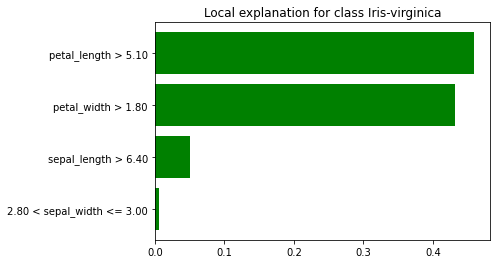

In [7]:
explanation = explainer.explain_instance(
    test_x.ravel(),
    model.predict_proba,
    num_features = 4,
    top_labels = 3
)
explanation.as_pyplot_figure(explanation.top_labels[0])
explanation.predict_proba   # probabilites from explained model

In [8]:
test_data

,sepal_length,sepal_width,petal_length,petal_width,label
112,6.8,3.0,5.5,2.1,Iris-virginica


In [9]:
print(explanation.get_prediction_for_explained_model())
print(explanation.get_prediction_for_surrogate_model())
print(explanation.get_prediction_for_surrogate_model(normalized=True))


[0.0, 0.0, 1.0]
[-0.04565398920386088, 0.02199270666740094, 1.0236612825364597]
[0.20066737347758137, 0.21471152324417375, 0.584621103278245]


In [10]:
top_features = explanation.as_map()[explanation.top_labels[0]]
top_features

[(2, 0.45906906298665584),
 (3, 0.43157957495159666),
 (0, 0.04982507820489026),
 (1, 0.005579340155229022)]

In [11]:
second_top_features = explanation.as_map()[explanation.top_labels[1]]
second_top_features

[(2, -0.25980447408805635),
 (3, -0.2153298926642214),
 (0, -0.017916268451883995),
 (1, 0.004636110962280916)]

In [12]:
explanation.as_map()

{0: [(3, -0.2162496822873754),
  (2, -0.19926458889859952),
  (0, -0.031908809753006265),
  (1, -0.010215451117509926)],
 1: [(2, -0.25980447408805635),
  (3, -0.2153298926642214),
  (0, -0.017916268451883995),
  (1, 0.004636110962280916)],
 2: [(2, 0.45906906298665584),
  (3, 0.43157957495159666),
  (0, 0.04982507820489026),
  (1, 0.005579340155229022)]}

In [13]:
explainer.discretizer.names

{0: ['sepal_length <= 5.10',
  '5.10 < sepal_length <= 5.80',
  '5.80 < sepal_length <= 6.40',
  'sepal_length > 6.40'],
 1: ['sepal_width <= 2.80',
  '2.80 < sepal_width <= 3.00',
  '3.00 < sepal_width <= 3.30',
  'sepal_width > 3.30'],
 2: ['petal_length <= 1.60',
  '1.60 < petal_length <= 4.30',
  '4.30 < petal_length <= 5.10',
  'petal_length > 5.10'],
 3: ['petal_width <= 0.30',
  '0.30 < petal_width <= 1.30',
  '1.30 < petal_width <= 1.80',
  'petal_width > 1.80']}

In [14]:
explainer.discretizer.maxs

{0: [5.1, 5.8, 6.4, 7.9],
 1: [2.8, 3.0, 3.3, 4.4],
 2: [1.6, 4.3, 5.1, 6.9],
 3: [0.3, 1.3, 1.8, 2.5]}

Update some attributes to see if probabilities would change

In [15]:
top_features = explanation.as_map()[predicted_label_id]
top_features

[(2, 0.45906906298665584),
 (3, 0.43157957495159666),
 (0, 0.04982507820489026),
 (1, 0.005579340155229022)]